In [1]:
import pandas as pd
import numpy as np

import os

from datetime import datetime
import time

import seaborn as sns
import matplotlib.pyplot as plt

import statistics

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the Iris dataset
# iris = load_iris()
# X = iris.data
# y = iris.target

from keras.models import Sequential
from keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings('ignore')

2023-06-02 02:26:59.004382: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 02:26:59.877888: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tensorflow as tf

In [3]:
if os.path.exists('dftrain.csv'):
    dftrain = pd.read_csv('dftrain.csv')
if os.path.exists('dftest.csv'):
    dftest = pd.read_csv('dftest.csv')

In [4]:
df_cleaned = pd.read_csv('train_cleaned.csv')

In [5]:
test_data = pd.read_csv('test_public.csv')

In [6]:
taxi_ids=list(set(test_data['TAXI_ID']))

In [7]:
dftest.head(1)

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA,TIMESTAMP
0,T1,20000542,2014,8,33,14,17,57,3,0,1,0,1,1,0,1408039037


<AxesSubplot:>

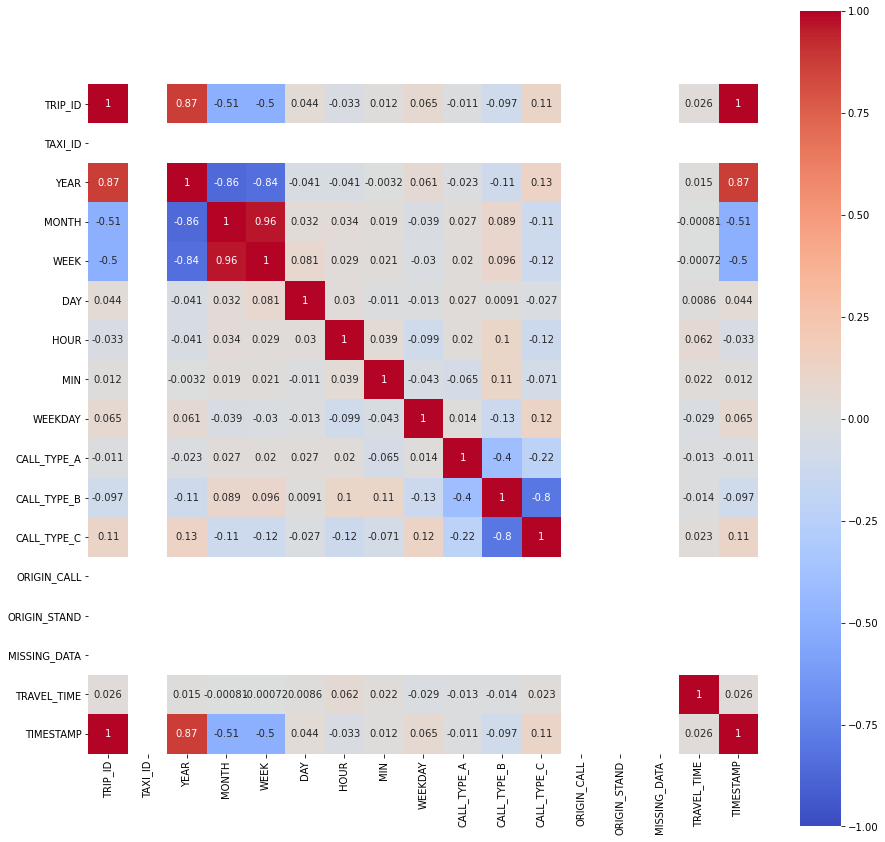

In [8]:
fig, ax = plt.subplots(figsize=(15,15))
new_train=dftrain[dftrain['TAXI_ID'] == 20000542]
sns.heatmap(new_train.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm',square=True)

## Get train/test for 1st taxi_id

In [9]:
trips_id = []
travel_preds = []

for taxi_id in [20000542]:
    newtrain=dftrain[dftrain['TAXI_ID'] == taxi_id]
    
    train_corr=newtrain[['TRAVEL_TIME', 'YEAR', 'MONTH', 'WEEK', 'DAY', 'HOUR', 'MIN', 'WEEKDAY']].corr()
    positive_corr_list=list(train_corr[train_corr > 0]['TRAVEL_TIME'].dropna().keys())
    positive_corr_list.remove('TRAVEL_TIME')

## Cut outliers

In [10]:
tmpdf = newtrain
Q1 = tmpdf['TRAVEL_TIME'].quantile(0.25)
Q3 = tmpdf['TRAVEL_TIME'].quantile(0.5)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

new_train = newtrain[newtrain.TRAVEL_TIME >= lower_bound]
new_train = newtrain[newtrain.TRAVEL_TIME <= upper_bound]

In [11]:
upper_bound

967.5

## One-hot encoding

In [12]:
years = {
    2013: [1, 0],
    2014: [0, 1]
}

tmp_day = np.zeros(len(new_train.DAY.unique()))
days = {}
for d in list(new_train.DAY):
    tmp = list(tmp_day)
    tmp[d-1] = tmp[d-1] + 1
    days[d] = tmp

In [13]:
tmp_hr = np.zeros(len(new_train.HOUR.unique()))
hrs = {}
for h in list(new_train.HOUR):
    tmp = list(tmp_hr)
    tmp[h-1] = tmp[h-1] + 1
    hrs[h] = tmp

In [14]:
tmp_min = np.zeros(len(new_train.MIN.unique()))
mins = {}
for m in list(new_train.MIN):
    tmp = list(tmp_min)
    tmp[m-1] = tmp[m-1] + 1
    mins[m] = tmp

In [15]:
positive_corr_list

['YEAR', 'DAY', 'HOUR', 'MIN']

In [16]:
tmp_travel_time = np.zeros(len(new_train.TRAVEL_TIME.unique()))
uniq_travels = new_train.TRAVEL_TIME.unique()
times = {}
for i in range(len(tmp_travel_time)):
    tmp = list(tmp_travel_time)
    tmp[i] = 1
    times[uniq_travels[i]] = tmp

In [17]:
Xtrain = []
ytrain = []

for row in new_train.iterrows():
    lst = []
    for elem in positive_corr_list:
        if elem == 'YEAR':
            lst = lst + years[row[1]['YEAR']]
        if elem == 'DAY':
            lst = lst + days[row[1]['DAY']]
        if elem == 'HOUR':
            lst = lst + hrs[row[1]['HOUR']]
        if elem == 'MIN':
            lst = lst + mins[row[1]['MIN']]
    Xtrain.append(np.array(lst))
    ytrain.append(np.array(times[row[1]['TRAVEL_TIME']]))

In [18]:
Xtrain = np.array(Xtrain)
ytrain = np.array(ytrain)

X_train = tf.convert_to_tensor(np.array(Xtrain[:int(Xtrain.shape[0]*2/3)]))
y_train = tf.convert_to_tensor(np.array(ytrain[:int(Xtrain.shape[0]*2/3)]))

X_val = tf.convert_to_tensor(np.array(Xtrain[int(Xtrain.shape[0]*2/3):]))
y_val = tf.convert_to_tensor(np.array(ytrain[int(Xtrain.shape[0]*2/3):]))

2023-06-02 02:27:23.948983: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10379 MB memory:  -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:3e:00.0, compute capability: 6.1


In [19]:
y_train.shape

TensorShape([3160, 65])

## True-value FE

In [20]:
Xtrain = []
ytrain = []

for row in new_train.iterrows():
    lst = []
    for elem in positive_corr_list:
        lst.append(row[1][elem])
    Xtrain.append(np.array(lst))
    ytrain.append(np.array(times[row[1]['TRAVEL_TIME']]))

In [21]:
Xtrain = np.array(Xtrain)
ytrain = np.array(ytrain)

X_train = tf.convert_to_tensor(np.array(Xtrain[:int(Xtrain.shape[0]*2/3)]))
y_train = tf.convert_to_tensor(np.array(ytrain[:int(Xtrain.shape[0]*2/3)]))

X_val = tf.convert_to_tensor(np.array(Xtrain[int(Xtrain.shape[0]*2/3):]))
y_val = tf.convert_to_tensor(np.array(ytrain[int(Xtrain.shape[0]*2/3):]))

In [22]:
new_test = dftest[dftest.TAXI_ID == 20000542]

In [23]:
dftest

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA,TIMESTAMP
0,T1,20000542,2014,8,33,14,17,57,3,0,1,0,1,1,0,1408039037
1,T2,20000108,2014,8,33,14,17,50,3,0,1,0,1,1,0,1408038611
2,T3,20000370,2014,8,33,14,17,49,3,0,1,0,1,1,0,1408038568
3,T4,20000492,2014,8,33,14,17,58,3,0,1,0,1,1,0,1408039090
4,T5,20000621,2014,8,33,14,17,59,3,0,1,0,1,1,0,1408039177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,T323,20000430,2014,12,51,21,14,18,6,1,0,0,1,1,0,1419171485
316,T324,20000020,2014,12,51,21,14,6,6,0,1,0,1,1,0,1419170802
317,T325,20000207,2014,12,51,21,14,28,6,0,0,1,1,1,0,1419172121
318,T326,20000667,2014,12,51,21,14,26,6,1,0,0,1,1,0,1419171980


## Deep Belief Networks (DBNs)

In [24]:
from tensorflow.keras.optimizers import SGD

# Create the DBN model
model = Sequential()

# Add the hidden layers
model.add(Dense(units=128, activation='sigmoid', input_shape=(Xtrain.shape[1],)))
model.add(Dense(units=128, activation='sigmoid'))
model.add(Dense(units=64, activation='sigmoid'))
model.add(Dense(units=64, activation='sigmoid'))
model.add(Dense(units=32, activation='sigmoid'))

# Add the output layer
model.add(Dense(units=len(times), activation='softmax'))

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the DBN
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100


2023-06-02 02:27:45.218232: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f65e4007840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-02 02:27:45.218279: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): GeForce GTX 1080 Ti, Compute Capability 6.1
2023-06-02 02:27:45.517906: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:417] Loaded runtime CuDNN library: 8.5.0 but source was compiled with: 8.6.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2023-06-02 02:27:45.543537: E tensorflow/compiler/xla/status_macros.cc:57] INTERNAL: RET_CHECK failure (tensorflow/compiler/xla/service/gpu/gpu_compiler.cc:618) dnn != nullptr 
*** Begin stack trace ***
	tsl::Cu

InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_10' defined at (most recent call last):
    File "/opt/conda/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2898, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2944, in _run_cell
      return runner(coro)
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3169, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3361, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_13846/4146499484.py", line 20, in <module>
      model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))
    File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1054, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/conda/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 543, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/conda/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 1174, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/conda/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 650, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/conda/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 1200, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/conda/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 1250, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/conda/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 1245, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_10'
RET_CHECK failure (tensorflow/compiler/xla/service/gpu/gpu_compiler.cc:618) dnn != nullptr 
	 [[{{node StatefulPartitionedCall_10}}]] [Op:__inference_train_function_1076]

In [53]:
Xtest = []
#ytrain = []

for row in new_test.iterrows():
    lst = []
    for elem in positive_corr_list:
        if elem == 'YEAR':
            lst = lst + years[row[1]['YEAR']]
        if elem == 'DAY':
            lst = lst + days[row[1]['DAY']]
        if elem == 'HOUR':
            lst = lst + hrs[row[1]['HOUR']]
        if elem == 'MIN':
            lst = lst + mins[row[1]['MIN']]
    Xtest.append(np.array(lst))
    #ytrain.append(np.array(times[row[1]['TRAVEL_TIME']]))

In [54]:
Xtest = np.array(Xtest)
X_test = tf.convert_to_tensor(np.array(Xtest))

In [163]:
# Make predictions
predicted_labels = np.argmax(model.predict(Xtest), axis=1)

1/1 [==============================] - 0s 86ms/step


In [164]:
predicted_labels

array([13, 13])

In [121]:
uniq_travels[13]

480

## MLP

In [55]:
X_train = tf.convert_to_tensor(np.array(Xtrain[:int(Xtrain.shape[0]*2/3)]))

ytrain = list(new_train.TRAVEL_TIME)
y_train = tf.convert_to_tensor(np.array(ytrain[:int(Xtrain.shape[0]*2/3)]))

X_val = tf.convert_to_tensor(np.array(Xtrain[int(Xtrain.shape[0]*2/3):]))
y_val = tf.convert_to_tensor(np.array(ytrain[int(Xtrain.shape[0]*2/3):]))

In [56]:
# Define the model
model = Sequential()
model.add(Dense(64, activation='softmax', input_dim=Xtrain.shape[1]))
model.add(Dense(64, activation='softmax'))
model.add(Dense(64, activation='softmax'))
model.add(Dense(64, activation='softmax'))
model.add(Dense(64, activation='softmax'))
model.add(Dense(1, activation='softmax'))

def root_mean_squared_error(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss=root_mean_squared_error, metrics=['mse'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/5


2023-06-01 23:58:54.387885: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:417] Loaded runtime CuDNN library: 8.5.0 but source was compiled with: 8.6.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2023-06-01 23:58:54.419634: E tensorflow/compiler/xla/status_macros.cc:57] INTERNAL: RET_CHECK failure (tensorflow/compiler/xla/service/gpu/gpu_compiler.cc:618) dnn != nullptr 
*** Begin stack trace ***
	tsl::CurrentStackTrace[abi:cxx11]()
	
	xla::status_macros::MakeErrorStream::Impl::GetStatus()
	xla::gpu::GpuCompiler::OptimizeHloModule(xla::HloModule*, stream_executor::StreamExecutor*, stream_executor::DeviceMemoryAllocator*, xla::gpu::GpuTargetConfig const&, xla::AutotuneResults const*)
	xla::gpu::GpuCompiler::RunHloPasses(std::unique_ptr<xla::Hl

InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_10' defined at (most recent call last):
    File "/opt/conda/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2898, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2944, in _run_cell
      return runner(coro)
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3169, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3361, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_9012/289510580.py", line 20, in <module>
      model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))
    File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1054, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/conda/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 543, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/conda/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 1174, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/conda/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 650, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/conda/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 1200, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/conda/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 1250, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/conda/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 1245, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_10'
RET_CHECK failure (tensorflow/compiler/xla/service/gpu/gpu_compiler.cc:618) dnn != nullptr 
	 [[{{node StatefulPartitionedCall_10}}]] [Op:__inference_train_function_5016]

In [58]:
%pip show tensorflow

Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.9/site-packages
Requires: google-pasta, astunparse, six, h5py, typing-extensions, tensorflow-io-gcs-filesystem, libclang, numpy, setuptools, tensorflow-estimator, protobuf, flatbuffers, gast, termcolor, wrapt, grpcio, tensorboard, absl-py, keras, packaging, opt-einsum, jax
Required-by: 
Note: you may need to restart the kernel to use updated packages.


## LDA

In [656]:
## in_data
for taxi_id in [20000542]:
    newtrain=dftrain[dftrain['TAXI_ID'] == taxi_id]
    
    train_corr=newtrain[['TRAVEL_TIME', 'YEAR', 'MONTH', 'WEEK', 'DAY', 'HOUR', 'MIN', 'WEEKDAY']].corr()
    positive_corr_list=list(train_corr[train_corr > 0]['TRAVEL_TIME'].dropna().keys())
    positive_corr_list.remove('TRAVEL_TIME')

## outlier cut
tmpdf = newtrain
Q1 = tmpdf['TRAVEL_TIME'].quantile(0.25)
Q3 = tmpdf['TRAVEL_TIME'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

new_train = newtrain[newtrain.TRAVEL_TIME >= lower_bound]
new_train = newtrain[newtrain.TRAVEL_TIME <= upper_bound]

upper_bound

1567.5

In [668]:
lower_bound

-292.5

In [657]:
positive_corr_list

['YEAR', 'DAY', 'HOUR', 'MIN']

In [658]:
new_train = newtrain

In [659]:
avail_times = new_train.TRAVEL_TIME.unique()
n = len(avail_times)
range_ = list(range(n))
labels = dict(zip(avail_times,range_))
labels_rev = dict(zip(range_, avail_times))

In [660]:
Xtrain = []
ytrain = []

for row in new_train.iterrows():
    
    lst = []
    for elem in ['YEAR', 'DAY', 'HOUR', 'MIN']:#, 'WEEKDAY']:
        lst.append(row[1][elem])

    Xtrain.append(np.array(lst))
    ytrain.append(np.array(labels[row[1]['TRAVEL_TIME']]))

In [661]:
n

228

In [662]:
X = Xtrain
y = ytrain

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99, random_state=42)

# Create an LDA classifier
lda = LinearDiscriminantAnalysis()

# Fit the LDA model on the training data
lda.fit(X_train, y_train)

# Predict the class labels for the test data
y_pred = lda.predict(X_train)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5689655172413793


In [663]:
new_test = dftest[dftest.TAXI_ID == 20000542]

In [664]:
Xtest = []
#ytest = []

for row in new_test.iterrows():
    lst = []
    for elem in ['YEAR', 'DAY', 'HOUR', 'MIN']:#, 'WEEKDAY']:
        lst.append(row[1][elem])
    Xtest.append(np.array(lst))
    #ytest.append(np.array(labels[row[1]['TRAVEL_TIME']]))

In [665]:
lda.predict(Xtest)

array([12, 33])

In [667]:
labels_rev[12]

495

In [408]:
print((585-labels_rev[17])**2)
print((210-labels_rev[4])**2)

225
81225


In [615]:
new_test

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA,TIMESTAMP
0,T1,20000542,2014,8,33,14,17,57,3,0,1,0,1,1,0,1408039037
300,T308,20000542,2014,12,51,21,11,41,6,0,0,1,1,1,0,1419162114


In [669]:
ytrain

[array(0),
 array(1),
 array(2),
 array(3),
 array(4),
 array(5),
 array(6),
 array(7),
 array(8),
 array(9),
 array(10),
 array(11),
 array(8),
 array(12),
 array(5),
 array(13),
 array(14),
 array(15),
 array(8),
 array(16),
 array(17),
 array(18),
 array(12),
 array(19),
 array(9),
 array(20),
 array(21),
 array(22),
 array(20),
 array(0),
 array(23),
 array(5),
 array(24),
 array(15),
 array(13),
 array(25),
 array(10),
 array(21),
 array(26),
 array(4),
 array(27),
 array(9),
 array(19),
 array(28),
 array(29),
 array(30),
 array(31),
 array(10),
 array(32),
 array(33),
 array(34),
 array(29),
 array(35),
 array(26),
 array(10),
 array(36),
 array(35),
 array(37),
 array(8),
 array(38),
 array(31),
 array(29),
 array(19),
 array(25),
 array(39),
 array(0),
 array(40),
 array(41),
 array(42),
 array(12),
 array(13),
 array(43),
 array(44),
 array(45),
 array(31),
 array(13),
 array(31),
 array(46),
 array(24),
 array(47),
 array(25),
 array(45),
 array(48),
 array(17),
 array(49),


## LDA (complete)

In [602]:
trips = []
preds = []
travel_preds = []
## in_data
for taxi_id in taxi_ids:
    print(taxi_id)
    if taxi_id in [20000312, 20000407, 20000510, 20000539,
                       20000079,20000100,20000185,20000248,20000294,20000071,
                      20000603,20000121,20000693,20000377, 20000494,20000547]:
        continue
    newtrain=dftrain[dftrain['TAXI_ID'] == taxi_id]
    

    ## outlier cut
    tmpdf = newtrain
    Q1 = tmpdf['TRAVEL_TIME'].quantile(0.25)
    Q3 = tmpdf['TRAVEL_TIME'].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = tmpdf['TRAVEL_TIME'].quantile(0.5)#Q3 + 1.5 * IQR

    new_train = newtrain[newtrain.TRAVEL_TIME >= lower_bound]
    new_train = newtrain[newtrain.TRAVEL_TIME <= upper_bound]

    # upper_bound
    #new_train = newtrain

    avail_times = new_train.TRAVEL_TIME.unique()
    n = len(avail_times)
    range_ = list(range(n))
    labels = dict(zip(avail_times,range_))
    labels_rev = dict(zip(range_, avail_times))

    Xtrain = []
    ytrain = []

    for row in new_train.iterrows():
        lst = []
        for elem in ['DAY']:#, 'WEEKDAY']:
            lst.append(row[1][elem])

        Xtrain.append(np.array(lst))
        ytrain.append(np.array(labels[row[1]['TRAVEL_TIME']]))

    X = Xtrain
    y = ytrain

    # Split the dataset into training and testing sets
#     if taxi_id not in [20000312, 20000407, 20000510, 20000539,
#                        20000079,20000100,20000185,20000248,20000294,20000071,
#                       20000603,20000121,20000693,20000377]:
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.99, random_state=42)
    #else:
        #X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.90, random_state=42)
    # Create an LDA classifier
    lda = LinearDiscriminantAnalysis()

    # Fit the LDA model on the training data
    lda.fit(X_train, y_train)
    
    new_test = dftest[dftest.TAXI_ID == taxi_id]
    
    Xtest = []

    for row in new_test.iterrows():
        trips.append(row[1]['TRIP_ID'])
        lst = []
        for elem in ['DAY']:#, 'WEEKDAY']:
            lst.append(row[1][elem])
        Xtest.append(np.array(lst))
        #ytest.append(np.array(labels[row[1]['TRAVEL_TIME']]))
    
    preds.append(lda.predict(Xtest))
    for pred in preds:
        for p in pred:
            if p in labels_rev:
                travel_preds.append(labels_rev[p])
            else:
                travel_preds.append(-1)
    #break

20000256
20000260
20000261
20000263
20000268
20000272
20000276
20000280
20000281
20000285
20000286
20000288
20000294
20000295
20000296
20000303
20000304
20000307
20000310
20000311
20000312
20000314
20000320
20000325
20000327
20000328
20000331
20000333
20000334
20000338
20000340
20000342
20000345
20000347
20000349
20000351
20000352
20000353
20000356
20000361
20000362
20000363
20000370
20000372
20000377
20000381
20000383
20000384
20000387
20000900
20000901
20000903
20000904
20000391
20000393
20000395
20000400
20000403
20000406
20000407
20000410
20000421
20000424
20000426
20000429
20000430
20000431
20000434
20000436
20000440
20000446
20000450
20000452
20000453
20000454
20000455
20000456
20000460
20000463
20000464
20000467
20000473
20000476
20000477
20000480
20000483
20000486
20000488
20000492
20000494
20000495
20000496
20000497
20000499
20000500
20000502
20000503
20000510
20000513
20000004
20000005
20000518
20000517
20000008
20000009
20000010
20000523
20000012
20000525
20000015
20000017
2

ValueError: The number of samples must be more than the number of classes.

In [677]:
y_train[0].item()

33

In [595]:
dcts=dict(zip(trips, travel_preds))

all_ids = list(test_data.TRIP_ID)

file1 = open("pred.csv", "w")
n = len(all_ids)
#line='"TRIP_ID","TRAVEL_TIME"\n'
#file1.write(line)
for i in range(n):
    print(dcts[all_ids[i]])
#     if i+1 != n:
#         line = '"' + all_ids[i] + '",' + str(dcts[all_ids[i]]) + '\n'
#     else:
#         line = '"' + all_ids[i] + '",'  + str(dcts[all_ids[i]])
#     file1.write(line)
file1.close()

405
420
1245
615
285
450
930
300
570
960
510
840
420
285
210
1110
435
735
795
1170
300
870
1290
675
450
1575
255
1260
675
1440
900
270
1425
870
675
1395
1035
1290
900
360
285
765
375
1425
225
135
570
1785
1230
375
1110
375
795
1110
735
360
1110
990
1035
825
660
405
810
1005
1005
420
495
870
885
285
810
555
1155
225
1245
885
1005
1785
1230
645
1110
1410
1050
1320
825
150
540
540
225
960
630
315
825
630
525
630
420
1350
495
450
150
735
345
210
495
720
0
240
435
1515
945
15
675
390
465
1350
60
300
1215
180
615
390
405
135
885
330
1500
630
630
660
855
525
1620
330
240
345
810
735
900
675
300
465
375
735
420
705
1710
525
300
930
450
795
540
780
255
1590
1335
1350
855
390
585
30
870
345
1050
1305
465
0
960
960
525
630
780
15
1620
510
300
675
300
1530
1035
1290
795
960
465
1365
390
990
780
1335
255
15
1665
705
450
1290
1080
585
1635
465
615
180
420
885
330
570
225
645
195
900
870
555
810
1275
660
540
1110
1485
1080
1455
345
960
480
960
480
105
930
1065
360
615
420
765
405
555
795
1155
720
510

In [574]:
all_ids

['T1',
 'T2',
 'T3',
 'T4',
 'T5',
 'T6',
 'T7',
 'T8',
 'T9',
 'T10',
 'T11',
 'T12',
 'T13',
 'T14',
 'T15',
 'T16',
 'T17',
 'T18',
 'T19',
 'T20',
 'T21',
 'T22',
 'T23',
 'T24',
 'T25',
 'T26',
 'T27',
 'T28',
 'T29',
 'T30',
 'T31',
 'T32',
 'T33',
 'T34',
 'T35',
 'T36',
 'T37',
 'T38',
 'T39',
 'T40',
 'T41',
 'T42',
 'T43',
 'T44',
 'T45',
 'T46',
 'T47',
 'T48',
 'T49',
 'T50',
 'T51',
 'T52',
 'T53',
 'T54',
 'T55',
 'T56',
 'T57',
 'T58',
 'T59',
 'T60',
 'T61',
 'T62',
 'T63',
 'T64',
 'T65',
 'T66',
 'T67',
 'T68',
 'T69',
 'T70',
 'T71',
 'T72',
 'T73',
 'T74',
 'T75',
 'T76',
 'T77',
 'T78',
 'T79',
 'T80',
 'T81',
 'T82',
 'T83',
 'T84',
 'T85',
 'T86',
 'T87',
 'T88',
 'T90',
 'T91',
 'T92',
 'T93',
 'T94',
 'T95',
 'T96',
 'T98',
 'T99',
 'T100',
 'T101',
 'T102',
 'T103',
 'T104',
 'T107',
 'T109',
 'T110',
 'T111',
 'T112',
 'T113',
 'T114',
 'T115',
 'T116',
 'T117',
 'T118',
 'T119',
 'T120',
 'T121',
 'T122',
 'T123',
 'T124',
 'T125',
 'T126',
 'T127',
 'T128',

## SVM

In [313]:
#from sklearn import svm

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an SVM classifier
clf = svm.SVC(kernel='sigmoid')

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.01263537906137184


In [314]:
clf.predict(Xtest)

array([15,  3])

In [316]:
labels_rev[15]

450

In [ ]:
 
    X_train = np.array(Xtrain)
    y_train = np.array(ytrain)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = np.reshape(y_train, (-1,1))


    model = Sequential()

    # Add input layer and first hidden layer
    model.add(Dense(units=128, activation='relu', input_dim=X_train.shape[1]))

    # Add additional hidden layers
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=16, activation='relu'))


    # Add output layer
    model.add(Dense(units=1, activation='relu'))

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=True)
    
    tmp_test=dftest[dftest['TAXI_ID'] == taxi_id]
    for row in tmp_test.iterrows():
        trip_id = row[1]['TRIP_ID']
        
        lst = []
        for elem in positive_corr_list:
            lst.append(row[1][elem])
            
        #Reshape your data either using array.reshape(-1, 1) if your data has a single feature 
        #or array.reshape(1, -1) if it contains a single sample.
        pred = model.predict(np.array(lst).reshape(1,-1))[0][0]
        
        travel_preds.append(pred)
        trips_id.append(trip_id)
        
        print(trip_id, pred)

In [274]:
positive_corr_list

['YEAR', 'DAY', 'HOUR', 'MIN']

In [9]:
X_train = np.array(Xtrain)
y_train = np.array(ytrain)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))


model = Sequential()

# Add input layer and first hidden layer
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))

# Add additional hidden layers
#model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))


# Add output layer
model.add(Dense(units=1, activation='relu'))

# Compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10)

Epoch 1/10


2023-05-26 06:32:18.397916: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:219] failed to create cublas handle: the library was not initialized
2023-05-26 06:32:18.398328: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:222] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2023-05-26 06:32:18.398394: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at matmul_op_impl.h:621 : INTERNAL: Attempting to perform BLAS operation using StreamExecutor without BLAS support
2023-05-26 06:32:18.398447: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:GPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: Attempting to perform BLAS oper

InternalError: Graph execution error:

Detected at node 'sequential_3/dense_15/MatMul' defined at (most recent call last):
    File "/opt/conda/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2898, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2944, in _run_cell
      return runner(coro)
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3169, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3361, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_28476/3966855020.py", line 26, in <module>
      model.fit(X_train, y_train, batch_size=32, epochs=10)
    File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/layers/core/dense.py", line 241, in call
      outputs = tf.matmul(a=inputs, b=self.kernel)
Node: 'sequential_3/dense_15/MatMul'
Attempting to perform BLAS operation using StreamExecutor without BLAS support
	 [[{{node sequential_3/dense_15/MatMul}}]] [Op:__inference_train_function_5028]

In [ ]:
tmp_test=dftest[dftest['TAXI_ID'] == 20000542]
preds = []   
for row in tmp_test.iterrows():
    trip_id = row[1]['TRIP_ID']

    lst = []
    for elem in positive_corr_list:
        lst.append(row[1][elem])

    #Reshape your data either using array.reshape(-1, 1) if your data has a single feature 
    #or array.reshape(1, -1) if it contains a single sample.
    pred = model.predict(np.array(lst).reshape(1,-1))[0]
    preds.append(pred)

In [13]:
dftrain

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA,TRAVEL_TIME
0,1372636858620000589,20000589,2013,7,27,1,0,0,0,0,0,1,1,1,0,330.0
1,1372637303620000596,20000596,2013,7,27,1,0,8,0,0,1,0,1,1,0,270.0
2,1372636951620000320,20000320,2013,7,27,1,0,2,0,0,0,1,1,1,0,960.0
3,1372636854620000520,20000520,2013,7,27,1,0,0,0,0,0,1,1,1,0,630.0
4,1372637091620000337,20000337,2013,7,27,1,0,4,0,0,0,1,1,1,0,420.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1674155,1388660427620000585,20000585,2014,1,1,2,11,0,3,0,0,1,1,1,0,2895.0
1674156,1404171463620000698,20000698,2014,6,27,30,23,37,0,0,0,1,1,1,0,465.0
1674157,1404171367620000670,20000670,2014,6,27,30,23,36,0,0,0,1,1,1,0,435.0
1674158,1404141826620000248,20000248,2014,6,27,30,15,23,0,0,1,0,1,1,0,915.0


In [14]:
test_data

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
0,T1,B,NaN,15.0,20000542,1408039037,A,False
1,T2,B,NaN,57.0,20000108,1408038611,A,False
2,T3,B,NaN,15.0,20000370,1408038568,A,False
3,T4,B,NaN,53.0,20000492,1408039090,A,False
4,T5,B,NaN,18.0,20000621,1408039177,A,False
...,...,...,...,...,...,...,...,...
315,T323,A,70885.0,NaN,20000430,1419171485,A,False
316,T324,B,NaN,53.0,20000020,1419170802,A,False
317,T325,C,NaN,NaN,20000207,1419172121,A,False
318,T326,A,76232.0,NaN,20000667,1419171980,A,False


In [15]:
train_cleaned = pd.read_csv('train_cleaned.csv')

In [17]:
df=train_cleaned

In [22]:
df['TRIP_ID'][df.duplicated('TRIP_ID')]

3720       1372702836620000080
21385      1373025987620000601
33350      1373210896620000598
51966      1373551710620000014
76596      1374014097620000337
                  ...         
1647665    1403115272620000066
1660290    1403323491620000600
1665292    1403407180620000242
1684729    1403716904620000337
1705655    1404093316620000307
Name: TRIP_ID, Length: 81, dtype: int64

In [20]:
np.nan in df['TRIP_ID']

False

In [21]:
np.nan in [np.nan]

True

In [41]:
df[df['TRIP_ID']==1373210896620000598]#['TAXI_ID'].reset_index().iloc[0]['TAXI_ID']

,Unnamed: 0,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK,DESCR,LAT,LON
33228,33228,1373210896620000598,B,NaN,57.0,20000598,1373210896,False,"[[-8.610885,41.145525]]",0,2013,7,7,15,6,São Bento,41.145719,-8.610707
33350,33350,1373210896620000598,C,NaN,NaN,20000598,1373210896,False,"[[-8.610813,41.14548],[-8.610732,41.145579],[-...",270,2013,7,7,15,6,NaN,NaN,NaN


In [32]:
dftest[dftest['TAXI_ID']==20000598]

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA


In [33]:
20000598 in test_data['TAXI_ID']

False

In [42]:
for i in df['TRIP_ID'][df.duplicated('TRIP_ID')]:
    if i in test_data['TAXI_ID']:
        print(i, df[df['TRIP_ID']==i]['TAXI_ID'].reset_index().iloc[0]['TAXI_ID'])

- There are 81 trip_id that is duplicated, and the taxi_id associated with them is not found in the test set

In [45]:
df_filtered = dftrain[~dftrain['TRIP_ID'].isin(dftrain['TRIP_ID'][dftrain.duplicated('TRIP_ID')])]

In [46]:
df_filtered.shape[0]

1674139

In [48]:
dftrain

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA,TRAVEL_TIME
0,1372636858620000589,20000589,2013,7,27,1,0,0,0,0,0,1,1,1,0,330.0
1,1372637303620000596,20000596,2013,7,27,1,0,8,0,0,1,0,1,1,0,270.0
2,1372636951620000320,20000320,2013,7,27,1,0,2,0,0,0,1,1,1,0,960.0
3,1372636854620000520,20000520,2013,7,27,1,0,0,0,0,0,1,1,1,0,630.0
4,1372637091620000337,20000337,2013,7,27,1,0,4,0,0,0,1,1,1,0,420.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1674155,1388660427620000585,20000585,2014,1,1,2,11,0,3,0,0,1,1,1,0,2895.0
1674156,1404171463620000698,20000698,2014,6,27,30,23,37,0,0,0,1,1,1,0,465.0
1674157,1404171367620000670,20000670,2014,6,27,30,23,36,0,0,0,1,1,1,0,435.0
1674158,1404141826620000248,20000248,2014,6,27,30,15,23,0,0,1,0,1,1,0,915.0


In [49]:
test_data

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
0,T1,B,NaN,15.0,20000542,1408039037,A,False
1,T2,B,NaN,57.0,20000108,1408038611,A,False
2,T3,B,NaN,15.0,20000370,1408038568,A,False
3,T4,B,NaN,53.0,20000492,1408039090,A,False
4,T5,B,NaN,18.0,20000621,1408039177,A,False
...,...,...,...,...,...,...,...,...
315,T323,A,70885.0,NaN,20000430,1419171485,A,False
316,T324,B,NaN,53.0,20000020,1419170802,A,False
317,T325,C,NaN,NaN,20000207,1419172121,A,False
318,T326,A,76232.0,NaN,20000667,1419171980,A,False


In [55]:
import statistics as st
st.median(df[df['ORIGIN_STAND']==15]['LEN'])

720

In [56]:
dftest[dftest['CALL_TYPE_B']==1]

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA
0,T1,20000542,2014,8,33,14,17,57,3,0,1,0,1,1,0
1,T2,20000108,2014,8,33,14,17,50,3,0,1,0,1,1,0
2,T3,20000370,2014,8,33,14,17,49,3,0,1,0,1,1,0
3,T4,20000492,2014,8,33,14,17,58,3,0,1,0,1,1,0
4,T5,20000621,2014,8,33,14,17,59,3,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,T298,20000158,2014,12,51,21,14,26,6,0,1,0,1,1,0
295,T303,20000067,2014,12,51,21,14,29,6,0,1,0,1,1,0
297,T305,20000320,2014,12,51,21,14,22,6,0,1,0,1,1,0
310,T318,20000325,2014,12,51,21,14,25,6,0,1,0,1,1,0


In [113]:
df_filtered = df[df['TAXI_ID'].isin(dftest['TAXI_ID'])]

<AxesSubplot:xlabel='MON', ylabel='Count'>

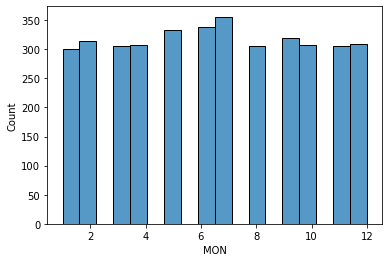

In [115]:
df_filtered = df_filtered[df_filtered.LEN==150]
sns.histplot(df_filtered.MON)

In [130]:
dftest.loc[0]

TRIP_ID               T1
TAXI_ID         20000542
YEAR                2014
MONTH                  8
WEEK                  33
DAY                   14
HOUR                  17
MIN                   57
WEEKDAY                3
CALL_TYPE_A            0
CALL_TYPE_B            1
CALL_TYPE_C            0
ORIGIN_CALL            1
ORIGIN_STAND           1
MISSING_DATA           0
Name: 0, dtype: object

<AxesSubplot:xlabel='TRAVEL_TIME'>

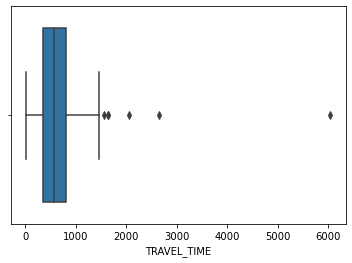

In [165]:
sns.boxplot(dftrain[(dftrain.TAXI_ID==20000542) & (dftrain.WEEK==33)]['TRAVEL_TIME'])

In [174]:
# taxis=list(dftest['TAXI_ID'])
# weeks=list(dftest['WEEK'])
# for i in [20000434]:
# taxi=taxis[i]
# week=weeks[i]
tmpdf = dftrain[(dftrain.TAXI_ID==20000434) & (dftrain.WEEK==41)]
Q1 = tmpdf['TRAVEL_TIME'].quantile(0.25)
Q3 = tmpdf['TRAVEL_TIME'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
df_filtered = tmpdf[(tmpdf['TRAVEL_TIME'] >= lower_bound) 
                    & (tmpdf['TRAVEL_TIME'] <= upper_bound)]
if len(df_filtered) > 0:
    print(st.mode(df_filtered['TRAVEL_TIME']))
else:
    print('skip')

570.0


In [176]:
st.mode(tmpdf['TRAVEL_TIME'])

570.0

In [144]:
150 in list(df_filtered['TRAVEL_TIME'])

True

In [168]:
dftest['TAXI_ID']

0      20000542
1      20000108
2      20000370
3      20000492
4      20000621
         ...   
315    20000430
316    20000020
317    20000207
318    20000667
319    20000255
Name: TAXI_ID, Length: 320, dtype: int64

In [222]:
dftest[(dftest['MONTH']==10)&(dftest['DAY']<=6) &(dftest['DAY']>=5)&(dftest['CALL_TYPE_A']==1)]#['TAXI_ID']

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA
151,T158,20000698,2014,10,41,6,17,42,0,1,0,0,1,1,0
153,T160,20000657,2014,10,41,6,17,42,0,1,0,0,1,1,0
157,T164,20000410,2014,10,41,6,17,43,0,1,0,0,1,1,0
160,T168,20000180,2014,10,41,6,17,36,0,1,0,0,1,1,0
162,T170,20000128,2014,10,41,6,17,38,0,1,0,0,1,1,0
164,T172,20000054,2014,10,41,6,17,40,0,1,0,0,1,1,0
167,T175,20000453,2014,10,41,6,17,40,0,1,0,0,1,1,0
177,T185,20000166,2014,10,41,6,17,43,0,1,0,0,1,1,0
178,T186,20000377,2014,10,41,6,17,30,0,1,0,0,1,1,0
179,T187,20000146,2014,10,41,6,17,38,0,1,0,0,1,1,0


In [185]:
np.percentile(dftrain.TRAVEL_TIME,99.75)

5460.0

In [220]:
dftest[dftest['TRIP_ID']=='T174']

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA
166,T174,20000624,2014,10,41,6,16,12,0,0,0,1,1,1,0


In [187]:
dftest

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA
0,T1,20000542,2014,8,33,14,17,57,3,0,1,0,1,1,0
1,T2,20000108,2014,8,33,14,17,50,3,0,1,0,1,1,0
2,T3,20000370,2014,8,33,14,17,49,3,0,1,0,1,1,0
3,T4,20000492,2014,8,33,14,17,58,3,0,1,0,1,1,0
4,T5,20000621,2014,8,33,14,17,59,3,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,T323,20000430,2014,12,51,21,14,18,6,1,0,0,1,1,0
316,T324,20000020,2014,12,51,21,14,6,6,0,1,0,1,1,0
317,T325,20000207,2014,12,51,21,14,28,6,0,0,1,1,1,0
318,T326,20000667,2014,12,51,21,14,26,6,1,0,0,1,1,0


In [189]:
for i in list(dftest['TAXI_ID']):
    if i not in list(dftrain['TAXI_ID']):
        print(i)

In [197]:
j=1
for i in list(dftest['TAXI_ID']):
    tmp=dftrain[dftrain.TAXI_ID==i]['TRAVEL_TIME']
    print('trip=',j, '; taxi_id=',i, '; min=', min(tmp), 'max=', max(tmp), '; mode=',st.mode(tmp), 
          '; median=',st.median(tmp), 
          '; 25th percentile=',np.percentile(tmp,25), 
          '; 75th percentile=',np.percentile(tmp,75), 
          '; 97.5th percentile=', np.percentile(tmp,97.5),
          '; 99.5th percentile=',np.percentile(tmp,99.5))
    print()
    j += 1

trip= 1 ; taxi_id= 20000542 ; min= 15.0 max= 17040.0 ; mode= 480.0 ; median= 630.0 ; 25th percentile= 420.0 ; 75th percentile= 885.0 ; 97.5th percentile= 1965.0 ; 99.5th percentile= 3780.0

trip= 2 ; taxi_id= 20000108 ; min= 15.0 max= 14880.0 ; mode= 600.0 ; median= 600.0 ; 25th percentile= 420.0 ; 75th percentile= 840.0 ; 97.5th percentile= 1710.0 ; 99.5th percentile= 2869.499999999989

trip= 3 ; taxi_id= 20000370 ; min= 15.0 max= 13860.0 ; mode= 405.0 ; median= 555.0 ; 25th percentile= 390.0 ; 75th percentile= 780.0 ; 97.5th percentile= 1560.0 ; 99.5th percentile= 2229.2999999999847

trip= 4 ; taxi_id= 20000492 ; min= 15.0 max= 10650.0 ; mode= 390.0 ; median= 540.0 ; 25th percentile= 375.0 ; 75th percentile= 780.0 ; 97.5th percentile= 1665.0 ; 99.5th percentile= 2840.625

trip= 5 ; taxi_id= 20000621 ; min= 15.0 max= 10650.0 ; mode= 435.0 ; median= 540.0 ; 25th percentile= 375.0 ; 75th percentile= 780.0 ; 97.5th percentile= 1605.0 ; 99.5th percentile= 2665.8750000000055

trip= 6 ; tax

In [ ]:
j=1
for i in list(dftest['TAXI_ID']):
    tmp=dftrain[dftrain.TAXI_ID==i]['TRAVEL_TIME']
    print('trip=',j, '; taxi_id=',i, '; min=', min(tmp), 'max=', max(tmp), '; mode=',st.mode(tmp), 
          '; median=',st.median(tmp), 
          '; 25th percentile=',np.percentile(tmp,25), 
          '; 75th percentile=',np.percentile(tmp,75), 
          '; 97.5th percentile=', np.percentile(tmp,97.5),
          '; 99.5th percentile=',np.percentile(tmp,99.5))
    print()
    j += 1

In [230]:
j=0
for i in list(dftest['TAXI_ID']):
    tmp=dftrain[(dftrain.TAXI_ID==i)]['TRAVEL_TIME']
#     if i in list(dftest[(dftest['MONTH']==10)&(dftest['DAY']<=6) &(dftest['DAY']>=5)&(dftest['CALL_TYPE_A']==1)]['TAXI_ID']):
#         p = np.percentile(tmp,99)
#     else:
    p=(np.percentile(tmp,25)+np.percentile(tmp,50)+np.percentile(tmp,75)+np.percentile(tmp,99))/8
    j += 1
    print(p)

626.1187500000005
521.25
462.76875000000075
483.28125
478.125
1206.1874999999995
483.0000000000007
607.8749999999997
453.89999999999986
556.2749999999996
609.1500000000002
526.8562499999996
509.62500000000034
1132.3687499999978
547.5
601.40625
508.85624999999976
735.6750000000011
600.8999999999992
610.8749999999986
493.125
564.375
551.25
657.1875
600.0
629.4000000000005
498.15000000000055
609.375
582.7874999999995
560.625
488.1937499999998
555.9375
487.5
602.7749999999992
646.875
568.2375
911.25
611.9249999999994
504.30000000000007
551.25
502.7437500000002
495.75000000000017
943.8375000000002
521.9249999999994
509.3624999999997
731.25
473.92499999999956
552.0562499999996
802.5
502.8374999999997
663.4124999999995
763.3499999999998
592.3312499999997
551.25
547.1250000000003
480.0
473.4750000000008
546.1499999999987
1010.625
553.7250000000004
575.6624999999999
489.375
465.6375000000003
582.9937500000005
457.5
584.9250000000001
495.2062499999994
519.0187499999973
562.4625000000001
450.8999

# Current Best Model

```
for i in list(dftest['TAXI_ID']):
    tmp=dftrain[dftrain.TAXI_ID==i]['TRAVEL_TIME']
    p=(np.percentile(tmp,25)+np.percentile(tmp,50)+np.percentile(tmp,75)+np.percentile(tmp,99.5))/9
```

In [ ]:
trips_id = []
travel_preds = []

for taxi_id in [20000542]:
    new_train=dftrain[dftrain['TAXI_ID'] == taxi_id]
#     train_corr=new_train[['TRAVEL_TIME', 'YEAR', 'MONTH', 'WEEK', 'DAY', 'HOUR', 'MIN', 'WEEKDAY']].corr()
#     positive_corr_list=list(train_corr[train_corr > 0]['TRAVEL_TIME'].dropna().keys())
#     positive_corr_list.remove('TRAVEL_TIME')

Xtrain = []
ytrain = []

for row in new_train.iterrows():
    lst = []
    for elem in ['WEEK']:
        lst.append(row[1][elem])

    Xtrain.append(np.array(lst))
    value = row[1]['TRAVEL_TIME'] #/ 15 + 1
    ytrain.append(np.array([value]))
    
    X_train = np.array(Xtrain)
    y_train = np.array(ytrain)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = np.reshape(y_train, (-1,1))

timesteps = X_train.shape[1]
features = X_train.shape[2]
num_classes = 1

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(timesteps, features)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='relu'))

# Compile the model
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10,verbose=False)#, validation_data=(X_val, y_val))

tmp_test=dftest[dftest['TAXI_ID'] == taxi_id]  
for row in tmp_test.iterrows():
    trip_id = row[1]['TRIP_ID']

    lst = []
    for elem in ['WEEK']:
        lst.append(row[1][elem])

    #Reshape your data either using array.reshape(-1, 1) if your data has a single feature 
    #or array.reshape(1, -1) if it contains a single sample.
    pred = model.predict(np.array(lst).reshape(1,-1))[0][0]
    print(trip_id,pred)
#         preds.append(pred)

#         travel_preds.append(pred)
#         trips_id.append(trip_id)

2023-06-02 00:27:50.310826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-02 00:27:50.313746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-02 00:27:50.314872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [229]:
for row in tmp_test.iterrows():
    trip_id = row[1]['TRIP_ID']

    lst = []
    for elem in ['WEEK']:
        lst.append(row[1][elem])

    #Reshape your data either using array.reshape(-1, 1) if your data has a single feature 
    #or array.reshape(1, -1) if it contains a single sample.
    pred = model.predict(np.array(lst).reshape(1,-1))[0][0]
    print(trip_id,pred)

2023-05-28 01:45:18.599020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 01:45:18.601448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 01:45:18.603154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 505ms/step
T1 0.0
1/1 [==============================] - 0s 40ms/step
T308 0.0


In [327]:
preds=[]
for i in list(dftest['TAXI_ID']):
    tmp=dftrain[(dftrain.TAXI_ID==i)]['TRAVEL_TIME']
#     if i in list(dftest[(dftest['MONTH']==10)&(dftest['DAY']<=6) &(dftest['DAY']>=5)&(dftest['CALL_TYPE_A']==1)]['TAXI_ID']):
#         p = np.percentile(tmp,99)
#     else:
    p=(np.percentile(tmp,25)+np.percentile(tmp,50)+np.percentile(tmp,75)+np.percentile(tmp,99.5))/9
    preds.append(p)
    #print(p)

In [328]:
all_ids = list(test_data.TRIP_ID)

file1 = open("pred_151b.csv", "w")
n = len(all_ids)
line='"TRIP_ID","TRAVEL_TIME"\n'
file1.write(line)
for i in range(n):
    if i+1 != n:
        line = '"' + all_ids[i] + '",' + str(preds[i]) + '\n'
    else:
        line = '"' + all_ids[i] + '",'  + str(preds[i])
    file1.write(line)
    print(preds[i])
file1.close()

635.0
525.4999999999987
439.36666666666497
503.9583333333333
484.54166666666725
1244.3166666666677
476.33333333333513
616.8666666666664
453.4666666666665
579.316666666667
621.5333333333305
564.4416666666666
522.4166666666664
1170.1666666666704
607.483333333333
628.0999999999995
491.15833333333364
751.2833333333341
625.6166666666664
615.7916666666688
464.3666666666665
573.7916666666675
530.0
770.4166666666666
610.4666666666648
705.4333333333337
510.0
621.9166666666675
576.3666666666662
528.6166666666668
506.31666666666507
549.5833333333334
478.6000000000013
594.1333333333326
681.6666666666666
573.433333333334
938.5249999999996
611.7000000000007
513.3333333333334
546.6666666666666
490.9416666666667
517.3333333333327
1019.4666666666672
524.6166666666674
509.7166666666665
833.2416666666662
466.5000000000009
551.6666666666666
919.7250000000024
486.96666666666715
661.3666666666662
787.5166666666667
809.8499999999998
579.1499999999996
526.3333333333321
463.3333333333333
442.71666666666687
514

In [235]:
dftest.MONTH.unique()

array([ 8,  9, 10, 11, 12])

In [256]:
dftest[(dftest.MONTH==11) & (dftest.HOUR==2)]

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA
280,T288,20000334,2014,11,44,1,2,40,5,0,0,1,1,1,0


In [265]:
np.percentile(dftrain[(dftrain.MONTH==11) & (dftrain.HOUR==2)]['TRAVEL_TIME'],25)

345.0

On the test set
- Aug: 14/8
- Sep: 30/9
- Oct: 6/10
- Nov: 1/11
- Dec: 21/12

In [248]:
duplicate(dftest[(dftest.MONTH==10)]['TAXI_ID'])

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA


In [299]:
dftest[dftest.TAXI_ID==20000129]

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA
33,T34,20000129,2014,8,33,14,17,59,3,0,0,1,1,1,0
188,T196,20000129,2014,10,41,6,17,41,0,0,1,0,1,1,0
255,T263,20000129,2014,11,44,1,3,56,5,0,0,1,1,1,0


In [300]:
test_data

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
0,T1,B,NaN,15.0,20000542,1408039037,A,False
1,T2,B,NaN,57.0,20000108,1408038611,A,False
2,T3,B,NaN,15.0,20000370,1408038568,A,False
3,T4,B,NaN,53.0,20000492,1408039090,A,False
4,T5,B,NaN,18.0,20000621,1408039177,A,False
...,...,...,...,...,...,...,...,...
315,T323,A,70885.0,NaN,20000430,1419171485,A,False
316,T324,B,NaN,53.0,20000020,1419170802,A,False
317,T325,C,NaN,NaN,20000207,1419172121,A,False
318,T326,A,76232.0,NaN,20000667,1419171980,A,False


In [329]:
model1=pd.read_csv('outputs/withBracket_pred.csv')
model2=pd.read_csv('outputs/withPercentile_pred.csv')

In [330]:
preds=(model1.TRAVEL_TIME + model2.TRAVEL_TIME)/2

In [331]:
preds

0      555.000000
1      608.750000
2      449.183333
3      488.854167
4      518.020833
          ...    
315    484.416667
316    521.175000
317    851.191667
318    605.950000
319    549.666667
Name: TRAVEL_TIME, Length: 320, dtype: float64

In [332]:
all_ids = list(test_data.TRIP_ID)

file1 = open("pred_151b.csv", "w")
n = len(all_ids)
line='"TRIP_ID","TRAVEL_TIME"\n'
file1.write(line)
for i in range(n):
    if i+1 != n:
        line = '"' + all_ids[i] + '",' + str(preds[i]) + '\n'
    else:
        line = '"' + all_ids[i] + '",'  + str(preds[i])
    file1.write(line)
    print(preds[i])
file1.close()

555.0
608.7499999999993
449.1833333333325
488.85416666666663
518.0208333333336
1050.1583333333338
532.7916666666675
758.1833333333332
476.23333333333323
573.1583333333335
567.7666666666653
662.7208333333333
479.9583333333332
1123.5833333333353
680.4916666666666
697.5499999999997
589.8291666666668
797.0166666666671
579.8083333333332
577.3958333333344
586.6833333333333
662.8958333333337
604.875
653.7083333333333
669.7333333333324
631.9666666666669
505.625
675.7083333333337
528.3083333333332
595.5583333333334
455.9083333333325
654.2916666666667
538.0500000000006
636.8166666666664
814.5833333333333
487.466666666667
911.7624999999998
690.3500000000004
561.6666666666667
590.2083333333333
702.0958333333333
468.79166666666634
856.9833333333336
524.5583333333336
528.1083333333332
661.3708333333332
599.7500000000005
794.5833333333333
821.8625000000012
559.1083333333336
667.4333333333332
718.8833333333333
784.3
605.3249999999998
626.1666666666661
484.29166666666663
524.2333333333335
626.595833333

In [316]:
for i in model2.TRAVEL_TIME:
    print(i)

626.1187500000005
521.25
462.7687500000008
483.28125
478.125
1206.1874999999995
483.0000000000007
607.8749999999997
453.8999999999999
556.2749999999996
609.1500000000002
526.8562499999996
509.62500000000034
1132.3687499999978
547.5
601.40625
508.85624999999976
735.6750000000011
600.8999999999992
610.8749999999986
493.125
564.375
551.25
657.1875
600.0
629.4000000000005
498.15000000000055
609.375
582.7874999999995
560.625
488.1937499999998
555.9375
487.5
602.7749999999992
646.875
568.2375
911.25
611.9249999999994
504.30000000000007
551.25
502.7437500000002
495.75000000000017
943.8375000000002
521.9249999999994
509.3624999999997
731.25
473.9249999999996
552.0562499999996
802.5
502.8374999999997
663.4124999999995
763.3499999999998
592.3312499999997
551.25
547.1250000000003
480.0
473.4750000000008
546.1499999999987
1010.625
553.7250000000004
575.6624999999999
489.375
465.6375000000003
582.9937500000005
457.5
584.9250000000001
495.2062499999994
519.0187499999973
562.4625000000001
450.8999999

<AxesSubplot:xlabel='LEN'>

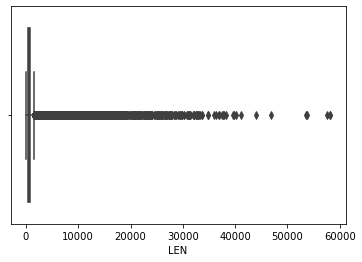

In [6]:
sns.boxplot(df_cleaned.LEN)

In [38]:
# taxis=list(dftest['TAXI_ID'])
# weeks=list(dftest['WEEK'])
# for i in [20000434]:
# taxi=taxis[i]
# week=weeks[i]
tmpdf = df_filtered
Q1 = tmpdf['TRAVEL_TIME'].quantile(0.25)
Q3 = tmpdf['TRAVEL_TIME'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
df_filtered1 = tmpdf[(tmpdf['TRAVEL_TIME'] >= lower_bound) 
                     & (tmpdf['TRAVEL_TIME'] <= upper_bound)]
# if len(df_filtered) > 0:
#     print(st.mode(df_filtered['TRAVEL_TIME']))
# else:
#     print('skip')

In [44]:
upper_bound

1567.5

In [43]:
df_filtered[df_filtered.TRAVEL_TIME > 10_000]

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,TRAVEL_TIME
2248,1372670258620000455,C,NaN,NaN,20000455,1372670258,A,False,"[[-8.611101,41.15529],[-8.611902,41.155371],[-...",13815
3545,1372684398620000352,C,NaN,NaN,20000352,1372684398,A,False,"[[-8.602227,41.150583],[-8.602344,41.152077],[...",11790
4029,1372701407620000520,C,NaN,NaN,20000520,1372701407,A,False,"[[-8.661789,41.147406],[-8.664183,41.147955],[...",12015
5490,1372665682620000084,C,NaN,NaN,20000084,1372665682,A,False,"[[-8.630793,41.154606],[-8.630829,41.154309],[...",13125
10568,1372781638620000250,C,NaN,NaN,20000250,1372781638,A,False,"[[-7.735365,41.294907],[-7.73559,41.295087],[-...",10665
...,...,...,...,...,...,...,...,...,...,...
1708861,1404133852620000197,B,NaN,60.0,20000197,1404133852,A,False,"[[-8.609643,41.151303],[-8.609652,41.151303],[...",12345
1708941,1404130881620000206,C,NaN,NaN,20000206,1404130881,A,False,"[[-8.602065,41.150232],[-8.602137,41.150313],[...",13125
1709073,1404120069620000073,C,NaN,NaN,20000073,1404120069,A,False,"[[-8.667414,41.161671],[-8.667423,41.161671],[...",23430
1709232,1404108872620000902,C,NaN,NaN,20000902,1404108872,A,False,"[[-8.682084,41.158773],[-8.682102,41.158764],[...",15075


In [51]:
np.percentile(df_filtered.TRAVEL_TIME,99.95)

10785.0

In [56]:
taxi_ids=list(dftest.TAXI_ID)

In [25]:
df = pd.read_csv('train.csv')

In [26]:
times = df.POLYLINE.apply(lambda x: max((x.count('[')-1-1)*15, 0)) # if (x.count('[')-1-1)*15 > 0 else np.nan)
df = df.assign(TRAVEL_TIME = times)

In [36]:
df_filtered = df[df.MISSING_DATA != True]

In [37]:
df_filtered.TRAVEL_TIME.max()

58200

- no missing data in the test set

In [57]:
df_filtered = df_filtered[df_filtered.TRAVEL_TIME < np.percentile(df_filtered.TRAVEL_TIME,99.95)]

In [88]:
t1 = df[df.TAXI_ID==taxi_ids[200]]

In [89]:
t1[t1.TRAVEL_TIME == t1.TRAVEL_TIME.max()]

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,TRAVEL_TIME
258729,1377735814620000356,B,NaN,15.0,20000356,1377735814,A,False,"[[-8.586063,41.148909],[-8.58762,41.149251],[-...",11970


In [83]:
datetime.fromtimestamp(1375919001)

datetime.datetime(2013, 8, 7, 23, 43, 21)

<AxesSubplot:xlabel='TRAVEL_TIME'>

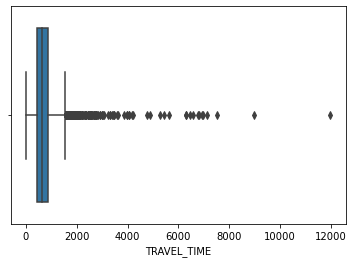

In [90]:
sns.boxplot(t1.TRAVEL_TIME)

In [68]:
dftest[dftest.TAXI_ID==taxi_ids[200]]

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA
200,T208,20000356,2014,10,41,6,15,12,0,0,0,1,1,1,0


In [63]:
tmpdf = t1
Q1 = tmpdf['TRAVEL_TIME'].quantile(0.25)
Q3 = tmpdf['TRAVEL_TIME'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [91]:
df[df.TRAVEL_TIME == df.TRAVEL_TIME.max()]

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,TRAVEL_TIME
1093727,1393061275620000681,C,NaN,NaN,20000681,1393061275,A,False,"[[-8.583435,41.158665],[-8.582958,41.158899],[...",58200


In [94]:
dftrain.corr()

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA,TRAVEL_TIME
TRIP_ID,1.000000,-0.001502,0.869592,-0.509085,-0.499938,0.067491,-0.019728,0.001571,0.018385,0.002146,-0.023349,0.023528,NaN,NaN,-0.000690,0.008460
TAXI_ID,-0.001502,1.000000,0.001145,-0.003322,-0.003081,-0.002344,-0.012360,0.002757,0.021025,-0.039728,-0.013108,0.050000,NaN,NaN,0.002130,0.014255
YEAR,0.869592,0.001145,1.000000,-0.865639,-0.843203,-0.018801,-0.019655,0.001590,0.010306,0.004415,-0.022901,0.021000,NaN,NaN,-0.001079,0.003655
MONTH,-0.509085,-0.003322,-0.865639,1.000000,0.965413,0.017073,0.010190,-0.001379,0.002304,-0.006156,0.015480,-0.011345,NaN,NaN,0.001224,0.001772
WEEK,-0.499938,-0.003081,-0.843203,0.965413,1.000000,0.069588,0.008136,-0.001152,0.007167,-0.006286,0.017532,-0.013465,NaN,NaN,0.001215,0.002470
DAY,0.067491,-0.002344,-0.018801,0.017073,0.069588,1.000000,0.018916,0.000750,-0.014688,0.004625,0.007632,-0.012478,NaN,NaN,-0.000395,0.003913
HOUR,-0.019728,-0.012360,-0.019655,0.010190,0.008136,0.018916,1.000000,-0.002944,-0.137938,0.040660,0.108566,-0.154914,NaN,NaN,0.000206,0.031993
MIN,0.001571,0.002757,0.001590,-0.001379,-0.001152,0.000750,-0.002944,1.000000,-0.007654,-0.012956,0.025754,-0.016434,NaN,NaN,-0.000361,0.000811
WEEKDAY,0.018385,0.021025,0.010306,0.002304,0.007167,-0.014688,-0.137938,-0.007654,1.000000,-0.048157,-0.060164,0.108881,NaN,NaN,0.000630,-0.049312
CALL_TYPE_A,0.002146,-0.039728,0.004415,-0.006156,-0.006286,0.004625,0.040660,-0.012956,-0.048157,1.000000,-0.508486,-0.344436,NaN,NaN,-0.000486,0.017330


In [101]:
trips_id = []
travel_preds = []

for taxi_id in taxi_ids[0:1]:
    new_train=dftrain[dftrain['TAXI_ID'] == taxi_id]
    train_corr=new_train[['TRAVEL_TIME', 'YEAR', 'MONTH', 'WEEK', 'DAY', 'HOUR', 'MIN', 'WEEKDAY']].corr()
    positive_corr_list=list(train_corr[train_corr > 0]['TRAVEL_TIME'].dropna().keys())
    positive_corr_list.remove('TRAVEL_TIME')

Xtrain = []
ytrain = []

for row in new_train.iterrows():
    lst = []
    for elem in positive_corr_list:
        lst.append(row[1][elem])

    Xtrain.append(np.array(lst))
    value = row[1]['TRAVEL_TIME'] #/ 15 + 1
    ytrain.append(np.array([value]))
    
    X_train = np.array(Xtrain)
    y_train = np.array(ytrain)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = np.reshape(y_train, (-1,1))

    timesteps = X_train.shape[1]
    features = X_train.shape[2]
    num_classes = 1

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(timesteps, features)))
model.add(Dense(64, activation='relu'))
#model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='relu'))

# Compile the model
model.compile(loss='mae', optimizer='sgd', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=150,verbose=True)#, validation_data=(X_val, y_val))

tmp_test=dftest[dftest['TAXI_ID'] == taxi_id]  
for row in tmp_test.iterrows():
    trip_id = row[1]['TRIP_ID']

    lst = []
    for elem in positive_corr_list:
        lst.append(row[1][elem])

    #Reshape your data either using array.reshape(-1, 1) if your data has a single feature 
    #or array.reshape(1, -1) if it contains a single sample.
    pred = model.predict(np.array(lst).reshape(1,-1))[0][0]
    print(trip_id,pred)
#         preds.append(pred)
        
#         travel_preds.append(pred)
#         trips_id.append(trip_id)

2023-05-29 16:36:02.257748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-29 16:36:02.259349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-29 16:36:02.261688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/150


2023-05-29 16:36:02.698189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-29 16:36:02.700162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-29 16:36:02.701558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

179/179 [==============================] - 3s 7ms/step - loss: 404.3230 - accuracy: 0.0000e+00
Epoch 2/150
179/179 [==============================] - 1s 7ms/step - loss: 332.6851 - accuracy: 0.0000e+00
Epoch 3/150
179/179 [==============================] - 1s 7ms/step - loss: 332.1812 - accuracy: 0.0000e+00
Epoch 4/150
179/179 [==============================] - 1s 7ms/step - loss: 331.8935 - accuracy: 0.0000e+00
Epoch 5/150
179/179 [==============================] - 1s 7ms/step - loss: 331.6771 - accuracy: 0.0000e+00
Epoch 6/150
179/179 [==============================] - 1s 7ms/step - loss: 331.6803 - accuracy: 0.0000e+00
Epoch 7/150
179/179 [==============================] - 1s 7ms/step - loss: 330.6538 - accuracy: 0.0000e+00
Epoch 8/150
179/179 [==============================] - 1s 7ms/step - loss: 331.2074 - accuracy: 0.0000e+00
Epoch 9/150
179/179 [==============================] - 1s 7ms/step - loss: 330.5596 - accuracy: 0.0000e+00
Epoch 10/150
179/179 [===========================

2023-05-29 16:39:16.745989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-29 16:39:16.747511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-29 16:39:16.749052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

T1 621.2972
1/1 [==============================] - 0s 26ms/step
T308 620.2324


<AxesSubplot:xlabel='LEN'>

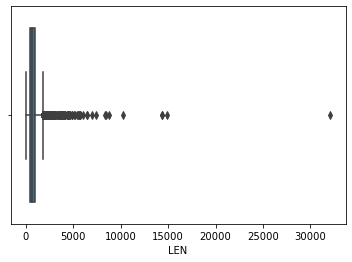

In [10]:
sns.boxplot(df_cleaned[df_cleaned.TAXI_ID == taxi_ids[0]].LEN)

In [10]:
tmp=df_cleaned[df_cleaned.TAXI_ID == taxi_ids[0]].LEN

Q1 = np.percentile(tmp,25)
Q3 = np.percentile(tmp,75)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
tmp = tmp[(tmp >= lower_bound) & (tmp <= upper_bound)]
# if len(df_filtered) > 0:
#     print(st.mode(df_filtered['TRAVEL_TIME']))
# else:
#     print('skip')

<AxesSubplot:xlabel='LEN'>

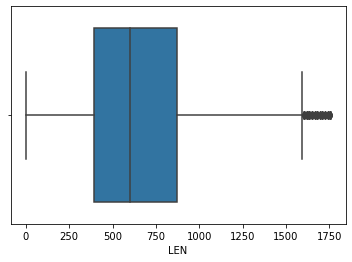

In [11]:
sns.boxplot(tmp)

In [18]:
Q1 = np.percentile(tmp,25)
Q3 = np.percentile(tmp,75)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
tmp = tmp[(tmp >= lower_bound) & (tmp <= upper_bound)]

<AxesSubplot:xlabel='LEN'>

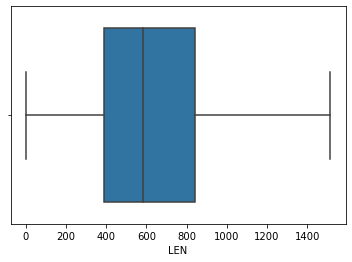

In [19]:
sns.boxplot(tmp)

In [30]:
len(tmp.unique())

102

In [21]:
tmp.max()

1515

In [43]:
tmp=df_cleaned[(df_cleaned.TAXI_ID == taxi_ids[0]) & (df_cleaned.MON == 8)].LEN
print(tmp.unique(), tmp.max(), len(tmp.unique()))

[ 285  375  810  510  735  600  720  900 1080  450 1635  405  705  795
 1440  690 1035 2685 1200  180  330  270  585  675  540  225  465  495
  825 1770  555  750  120 1005  300  390  480 1230 1260  945  345  780
  435 4845 2400  615  885 1125  660 1965 2460  990  360  525  420  210
  315 2295  630 1170 3840 1935  855 5550 1245  840 1185  870 1680 2385
 1020 1050 1995  915 1425  765  570  645  960 2970 1980 3435 1155  255
 1380 1740 1095 1500  165  240 3600  135 1485 2085 6945 1395 1365  105
 1410 2895 2340  975 1110 1710 1455 1065  930 1140] 6945 108


In [35]:
dftest

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA
0,T1,20000542,2014,8,33,14,17,57,3,0,1,0,1,1,0
1,T2,20000108,2014,8,33,14,17,50,3,0,1,0,1,1,0
2,T3,20000370,2014,8,33,14,17,49,3,0,1,0,1,1,0
3,T4,20000492,2014,8,33,14,17,58,3,0,1,0,1,1,0
4,T5,20000621,2014,8,33,14,17,59,3,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,T323,20000430,2014,12,51,21,14,18,6,1,0,0,1,1,0
316,T324,20000020,2014,12,51,21,14,6,6,0,1,0,1,1,0
317,T325,20000207,2014,12,51,21,14,28,6,0,0,1,1,1,0
318,T326,20000667,2014,12,51,21,14,26,6,1,0,0,1,1,0


In [7]:
dftest[dftest.TAXI_ID == taxi_ids[0]]

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA
73,T74,20000256,2014,8,33,14,17,40,3,0,0,1,1,1,0
245,T253,20000256,2014,11,44,1,3,38,5,0,0,1,1,1,0


In [ ]:
# T253 -- time = 1260
# T74 -- time = 1155

In [25]:
uniq_labels = len(tmp.unique())

In [52]:
encoding_labels = list(range(uniq_labels))
dicts = dict(zip(tmp.unique(), encoding_labels))

In [26]:
# Dummy training data
X_train = np.random.random((1000, 10))
y_train = np.random.randint(0, 3, (1000,))

In [36]:
df = pd.read_csv('train.csv')

In [39]:
times = df.POLYLINE.apply(lambda x: max((x.count('[')-1-1)*15, 0)) # if (x.count('[')-1-1)*15 > 0 else np.nan)
df = df.assign(TRAVEL_TIME = times)

In [119]:
dftrain = dftrain.dropna()

In [120]:
df_filtered = dftrain[dftrain.MISSING_DATA != True]
tmpdf = df_filtered[df_filtered.TAXI_ID == taxi_ids[0]]

In [121]:
tmpdf = tmpdf[tmpdf.TRAVEL_TIME <= 1515]

In [122]:
X_train = []
y_train = []
for row in tmpdf.iterrows():
    #print(row[1])
    lst = [row[1]['MONTH'], row[1]['WEEK'], row[1]['MIN']]
    X_train.append(lst)
    y_train.append(row[1]['TRAVEL_TIME'])

In [123]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [124]:
for i in range(len(y_train)):
    y_train[i] = dicts[y_train[i]]

In [37]:
# Define the model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=3))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

2023-05-31 09:05:34.412962: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10379 MB memory:  -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:3e:00.0, compute capability: 6.1


AttributeError: 'list' object has no attribute 'shape'

In [153]:
# Predict on new data
X_test = np.array([X_train[10], X_train[12]])
y_pred = model.predict(X_test)
np.argmax(model.predict(X_test), axis=-1)

1/1 [==============================] - 0s 35ms/step


array([0, 0])

In [139]:
dftest[dftest.TRIP_ID == 'T73']

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA
72,T73,20000334,2014,8,33,14,17,57,3,0,1,0,1,1,0


In [138]:
tmpdf

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA,TRAVEL_TIME
346,1372638021620000256,20000256,2013,7,27,1,0,20,0,0,0,1,1,1,0,750.0
487,1372660598620000256,20000256,2013,7,27,1,6,36,0,0,0,1,1,1,0,795.0
682,1372664539620000256,20000256,2013,7,27,1,7,42,0,0,1,0,1,1,0,900.0
772,1372667190620000256,20000256,2013,7,27,1,8,26,0,1,0,0,1,1,0,585.0
986,1372668303620000256,20000256,2013,7,27,1,8,45,0,0,0,1,1,1,0,900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1671680,1404135567620000256,20000256,2014,6,27,30,13,39,0,1,0,0,1,1,0,795.0
1672228,1404137654620000256,20000256,2014,6,27,30,14,14,0,1,0,0,1,1,0,1155.0
1672492,1404144140620000256,20000256,2014,6,27,30,16,2,0,0,1,0,1,1,0,825.0
1673195,1404158391620000256,20000256,2014,6,27,30,19,59,0,0,1,0,1,1,0,300.0


In [77]:
test_data[test_data.TAXI_ID == taxi_ids[0]].TIMESTAMP[73]

1408038045

In [104]:
X_train[0]

array([ 7., 27.])

In [127]:
X_train

array([[ 7., 27., 20.],
       [ 7., 27., 36.],
       [ 7., 27., 42.],
       ...,
       [ 6., 27.,  2.],
       [ 6., 27., 59.],
       [ 6., 27., 24.]])

In [148]:
y_train

array([ 0.,  1.,  2., ..., 67., 60., 44.])